# Assignment 2

In this assignment you will analyse the [BCI Competition IV dataset IIa](http://www.bbci.de/competition/iv/#dataset2a) from the Graz University made available by Brunner, Leeb, Müller-Putz, Schlögl, and Pfurtscheller. This dataset contains EEG data recorded while nine participants operated a SMR based BCI using left-hand, right-hand, feet, and tongue movement imagery. The left-hand and right-hand data of participant 3 is processed and made available on Brightspace. Note, this was one of the "better" participants.


### Learning goals
After this assignment, you will
* have experience with the BCI cycle as applied to a SMR-based BCI
* have experience with applying a band-pass filter
* have experience with spatial filtering using the Laplacian and CSP

### Table of contents

1. [The dataset](#dataset)
    1. [The stimulus paradigm](#stimulus)
    2. [The EEG data](#eeg)
2. [Decoding the neural code](#neural)
    1. [Bandpower features](#bandpower)
    2. [Visualizing features](#features)
    3. [Decoding](#decoding)
4. [Extension: Laplacian spatial filter](#extension1)
    1. [The Laplacian](#laplacian)
    2. [Bandpower features](#bandpower2)
    3. [Visualizing features](#features2)
    4. [Decoding](#decoding2)
5. [Extension: Common spatial patterns](#extension2)
    1. [The CSP](#csp)
    2. [Bandpower features](#bandpower3)
    3. [Visualizing features](#features3)
    4. [Decoding](#decoding3)
    5. [Inspecting classifier](#classifier)
    

In [1]:
# Some imports
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Polygon
from scipy.interpolate import griddata
from scipy.signal import periodogram, butter, filtfilt
from scipy.linalg import eig, inv
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
def topoplot(z, c, cbar=False):
    """
    Function to plot a topoplot given the values at each electrode `z` and the electrode position file `c` that 
    denotes the electrode positions in polar coordinates.
    
    Args:
        z (numpy.ndarray): array of electrode values
        c (str): txt file containing electrode position information
        cbar (bool): whether or not to add a colorbar (default: False)
    """
    
    # Read electrode positions
    with open(c) as fid:
        lines = fid.read().split("\n")
        xy = np.zeros((len(lines), 2))
        for i, line in enumerate(lines):
            __, t, r, __ = line.split("\t")
            t = (float(t) + 90) / 180 * np.pi
            r = float(r) * 2
            xy[i, :] = r*np.cos(t), r*np.sin(t)
            
    # Add additional points for interpolation to edge of head
    xy = np.concatenate((xy, np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])), axis=0)
    z = np.concatenate((z, np.zeros((4,))), axis=None)

    # Make grid
    N = 300
    xi = np.linspace(-2, 2, N)
    yi = np.linspace(-2, 2, N)
    zi = griddata((xy[:, 0], xy[:, 1]), z, (xi[None,:], yi[:,None]), method="cubic", fill_value="nan")

    # Set points outside radius to nan so they will not be plotted (outside head).
    d = xi[1] - xi[0]
    for i in range(N):
        for j in range(N):
            if np.sqrt(xi[i]**2 + yi[j]**2) + d > 1:
                zi[j, i] = "nan"

    # Make figure
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect=1)
    
    # Add head
    circle = Circle(xy=[0,0], radius=1, edgecolor="k", facecolor="w", zorder=1)
    ax.add_patch(circle)

    # Add ears
    circle = Ellipse(xy=[-1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)
    circle = Ellipse(xy=[1,0], width=0.25, height=0.5, angle=0, edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(circle)

    # Add a nose
    polygon = Polygon(xy=[[-0.1,0.9], [0,1.25],[0.1,0.9]], edgecolor="k", facecolor="w", zorder=0)
    ax.add_patch(polygon) 

    # Add the interpolated data
    cs = ax.contourf(xi, yi, zi, 60, cmap=plt.cm.jet, zorder=2)
    ax.contour(xi, yi, zi, 15, colors="grey", zorder=3)

    # Add data points
    ax.scatter(xy[:-4,0], xy[:-4,1], marker="o", c="k", s=15, zorder=4)
    
    # Add color bar
    if cbar:
        fig.colorbar(cs, ax=ax)

    # Make the axis invisible 
    plt.axis("off")

    # set axes limits
    ax.set_xlim(1.25, -1.25)
    ax.set_ylim(-1.25, 1.25)
    

In [3]:
def confusionmatrix(T, Y):
    """
    Function to plot a confusion matrix.
    
    Args:
        T (ndarray): target labels
        Y (ndarray): predicted labels
    """

    # Confusion matrix
    cm = confusion_matrix(T.flatten(), Y.flatten())

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           ylabel="True label",
           xlabel="Predicted label")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, "{}".format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    

# 1. The dataset<a class="anchor" id="dataset"></a>
Download the data to a specific location on your computer, and change the variable `path_to_data` accordingly. 

In [4]:
path_to_data = "./assignment2_data.npz"


To load the data, execute the cell below. It loads into memory a training set and a validation set of one participant. We will use the training set to inspect the data and calibrate a classifier, and the validation set to evaluate the performance of the classifier. In fact, in the original competition, one was not given the target values of the validation set, which had to be predicted and submitted and were evaluated to get a position on the [leaderboard](http://www.bbci.de/competition/iv/results/index.html). 

Some words on the dataset:
* $X \in \mathbb{R}^{k, m, c}$ are the EEG data of $k$ single-trials, $m$ samples, and $c$ channels. With single-trials we mean the participant is focusing on one symbol. With samples we mean time-points (to convert samples to time, use the samplefrequency, i.e., the number of samples per second (Hz)). With channels we mean the voltage difference between a recording and reference electrode.
* $T \in \mathbb{R}^{k}$ are the target labels of $k$ single-trials. This represents the ground truth, i.e., left or right hand movement imagery.

In [5]:
# Load the data
tmp = np.load(path_to_data)
X_train = tmp["X_train"]
T_train = tmp["T_train"]
X_valid = tmp["X_valid"]
T_valid = tmp["T_valid"]
channels = tmp["channels"].tolist()
fs = tmp["fs"]

# Print some properties
print("Data has timeseries of {} channels at {} Hz".format(len(channels), fs))
print("Channels:", channels)
print("Training data:")
print("\tX: ", X_train.shape, X_train.dtype)
print("\tT: ", T_train.shape, T_train.dtype)
print("Validation data:")
print("\tX: ", X_valid.shape, X_valid.dtype)
print("\tT: ", T_valid.shape, T_valid.dtype)


Data has timeseries of 22 channels at 250 Hz
Channels: ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
Training data:
	X:  (144, 750, 22) float32
	T:  (144,) uint8
Validation data:
	X:  (144, 750, 22) float32
	T:  (144,) uint8


### 1.1. The stimulus paradigm (0.25 points) <a class="anchor" id="stimulus"></a>
During the experiment, the participant imagined left-hand versus right-hand movement (originally also feet and tongue). Let's inspect whether we have a balanced dataset. Plot a histogram of the target labels in `T_train` using `plt.hist()`. 

Do we have a balanced dataset?

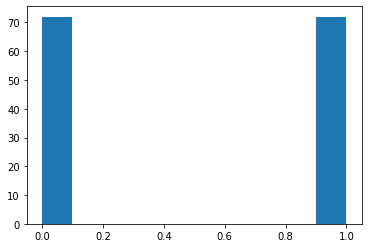

In [6]:
plt.hist(T_train)
plt.show()

_Yes, the data is balanced._

### 1.2. The EEG data (0.25 points) <a class="anchor" id="eeg"></a>
Let's inspect the EEG data itself. The variable `X_train` contains the EEG data, we have a list of the channel names `channels` so we know which channel was located where on the scalp, and we have the sample frequency `fs`, i.e., the number of measurements per second. 

Now, plot a trial (e.g., the first) of channel C3 and one of C4. Use `plt.plot()` to overlay them in the same figure.

Can you interpret the data visually, i.e., can you derive which hand movement (left versus right) the participant imagined? 


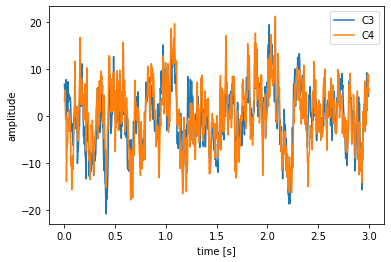

In [7]:
time_series = np.linspace(0, X_train.shape[1] / fs, X_train.shape[1])
plt.plot(time_series, X_train[0, :, channels.index('C3')], label='C3')
plt.plot(time_series, X_train[0, :, channels.index('C4')], label='C4')
plt.xlabel('time [s]')
plt.ylabel('amplitude')
plt.legend()

plt.show()

*Let's plot the smoothed signals in hope they're more legible.*

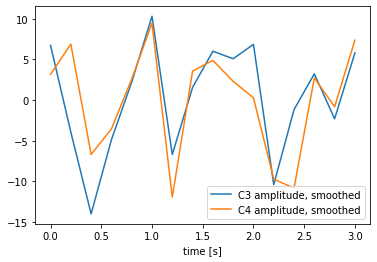

In [8]:
def plot_smoothed(channel, jagginess=16):
    from scipy.interpolate import make_interp_spline, BSpline
    
    samples = X_train[0, :, channels.index(channel)]
    time_series_filtered = np.linspace(time_series.min(), time_series.max(), jagginess)
    spl = make_interp_spline(time_series, samples, k=3)
    samples_smooth = spl(time_series_filtered)
    
    plt.plot(time_series_filtered, samples_smooth, label=f'{channel} amplitude, smoothed')
    plt.xlabel('time [s]')

plot_smoothed('C3')
plot_smoothed('C4')
plt.legend()
plt.show()

*We cannot tell whether this is right- or left-hand imagery - we haven't filtered the data by frequency or done a fourier transform, so we're just looking at an aggregate of sorts.*

The above visualization shows us the data in the temporal domain. Let's transform this data to the frequency-domain and inspect which frequencies are present in the data. Especially for SMR based BCI this is important.

Compute the frequency spectrum (i.e., power spectral density) of `X_train` using `periodogram()` from SciPy. Make sure the power spectrum is computed over the correct axis and with the correct samplefrequency. Then, plot the frequency spectrum of the same trial as above (e.g., the first) for channels C3 and C4. 

What do you observe? What can you say about the peaks in the lower spectrum, and what can you say about the peak at 50 Hz? Also, why do we see frequencies only up to 120 Hz when in fact our samplefrequency is higher?

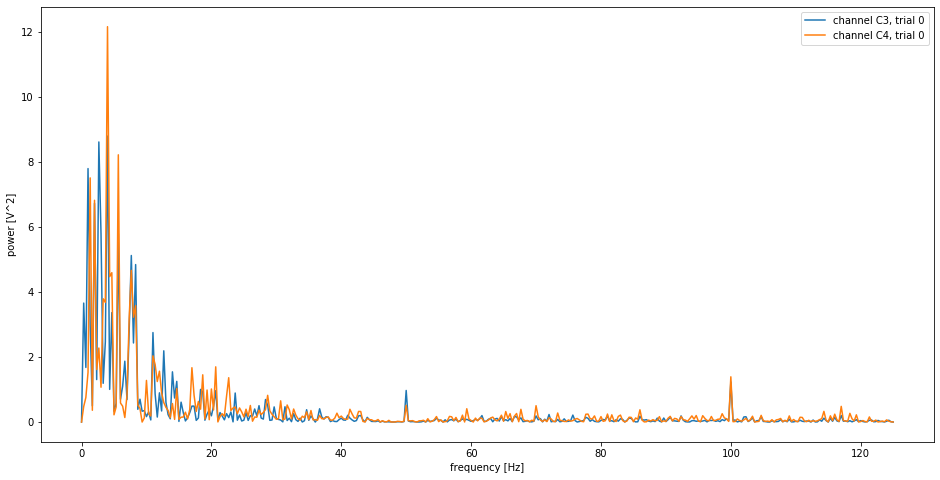

In [9]:
def get_spectrum(channel, trial=0):
    return periodogram(X_train[trial, :, channels.index(channel)], fs)

def plot_spectrum(channel, trial=0):
    frequencies, powers = get_spectrum(channel=channel, trial=trial)
    plt.plot(frequencies, powers, label=f'channel {channel}, trial {trial}')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('power [V^2]')

plt.figure(figsize=(16, 8))
plot_spectrum('C3')
plot_spectrum('C4')
plt.legend()
plt.show()

*The peaks in the lower spectrum are due to brain activity, but we still can't really read it with our eyes. The peak at 50Hz is due to the electric grid (and so is probaby 100Hz, the second harmonic of 50Hz). Actually, we see freuqencies up to 125Hz, which is exactly fs/2 - as Nyquist's theorem would have it.*

# 2. Decoding the neural code<a class="anchor" id="neural"></a>
In this assignment we work with SMRs. We know that these particularly occur at the mu (8-12 Hz) and beta (12-30 Hz) bands. In a SMR-based BCI, one way to go is to use the average power envelope of these bands as features. 

### 2.1. Bandpower features (2.0 point)<a class="anchor" id="bandpower"></a>
Implement two band-pass filters one with a cut-off frequency of 8 to 12 Hz and another with 12-30 Hz. To design the filters, use `butter()` from SciPy, and to apply the filter use `filtfilt` from SciPy. Note, there is plenty of choice in filter types and filter parameters to choose from. Here, use filters of order 5. Note, this step is not neccessarily a preprocessing step, but can be considered to be a feature selection step too. Obviously, these steps tend to be intertwined a lot.

Apply the filters to both the training data as well as the validation data, creating the variables `F_train` and `F_valid` that are of shape $F \in \mathbb{R}^{k,f,c}$, with $k$ the number of trials, $f$ the number of pass-bands (mu and beta), and $c$ the number of channels (C3 and C4).

What do the band-pass filters do? If you cannot answer these questions directly, look at what the data looks like before and after filtering.


In [10]:
def get_band(data, start, end, available_channels, channel_names):
    nyquist_frequency = fs / 2
    b, a = butter(5, [start / nyquist_frequency, end / nyquist_frequency], btype='bandpass')
    channel_indices = [available_channels.index(name) for name in channel_names]
    result = filtfilt(b, a, data[:, :, channel_indices], axis=1)
    result = np.log(result ** 2) # the transformation to dB has proven beneficial for accuracy metrics and plot prettiness
    return result.mean(axis=1) # we compute the mean power over the samples

def get_bands(data, bands, available_channels, channel_names):
    '''Band-pass filter some data. Resulting channels, in order: (trials, channels, bands)'''
    result = []
    for band in bands:
        result.append(get_band(data, band[0], band[1], available_channels, channel_names))
    return np.stack(result, axis=1)

F_train = get_bands(X_train, [(8, 12), (12, 30)], channels, ['C3', 'C4'])
F_valid = get_bands(X_valid, [(8, 12), (12, 30)], channels, ['C3', 'C4'])


In [11]:
print("F_train:", F_train.shape, F_train.dtype)
print("F_valid:", F_valid.shape, F_valid.dtype)

F_train: (144, 2, 2) float64
F_valid: (144, 2, 2) float64


In [12]:
pass_bands = ['mu', 'beta']
electrodes = ['C3', 'C4']
hands = ['left', 'right']

*Let's see if the data makes sense!*

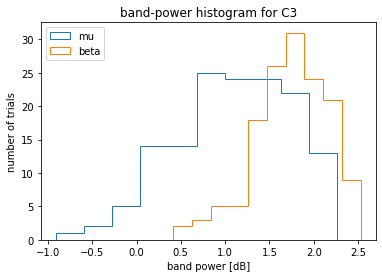

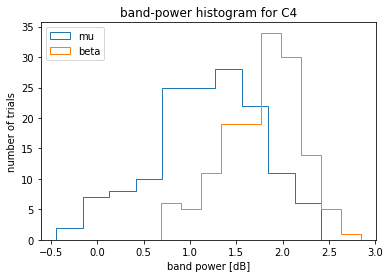

In [13]:
def power_histogram(data, electrode):
    plt.title(f'band-power histogram for {electrode}')
    plt.xlabel('band power [dB]')
    plt.ylabel('number of trials')
    plt.hist(F_train[:, pass_bands.index('mu'), electrodes.index(electrode)], histtype='step', label='mu')
    plt.hist(F_train[:, pass_bands.index('beta'), electrodes.index(electrode)], histtype='step', label='beta')
    plt.legend()
    plt.show()

power_histogram(F_train, 'C3')
power_histogram(F_train, 'C4')

*The band-pass filters select the given frequencies from the signal, yielding a result which is still in the time domain. We average the band powers over samples (each trial remains separate, but is condensed into only 4 values) because, in each trial, there was only one type of activity which we want to classify.*

### 2.2. Visualizing features (0.5 points)<a class="anchor" id="features"></a>
A first thing to check is that we processed the data correctly and that we actually recorded good SMRs. We can do so by computing averages over trials in the training data for individual classes: left-hand versus right-hand movement imagery.

Compute the mean features over all trials for left and for right hand movement imagery. Then, plot the averages as bar plots with `plt.bar()` showing the average C3 and C4 amplitude for both left as well as right hand movement imagery.

What can you observe from the visualization? Do you see clear lateralisation effects?

Note, we have plotted the averages only. Good practice would be to also plot the variance.

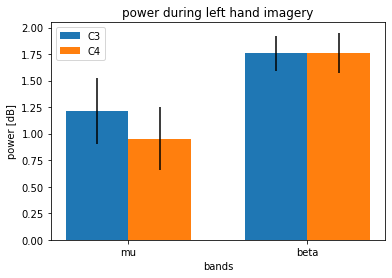

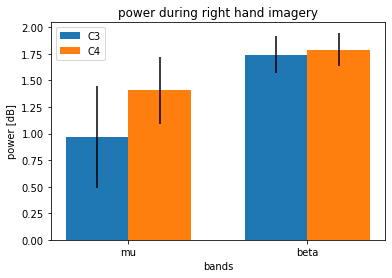

In [14]:
def electrode_power_bars(electrode, power, power_error):
    width = 0.35
    electrode_idx = electrodes.index(electrode)
    offset = electrode_idx * width - width / 2
    plt.bar(np.arange(power.shape[0]) + offset,
            power[:, electrode_idx],
            width,
            label=electrode,
            yerr=power_error[:, electrode_idx])

def hand_power_plot(data, labels, hand):
    power = data[labels == hands.index(hand)].mean(axis=0)
    power_error = data[labels == hands.index(hand)].var(axis=0)
    electrode_power_bars('C3', power, power_error)
    electrode_power_bars('C4', power, power_error)
    plt.legend()
    plt.xticks(np.arange(power.shape[0]), [f'{band}' for band in pass_bands ])
    plt.title(f'power during {hand} hand imagery')
    plt.xlabel('bands')
    plt.ylabel('power [dB]')
    plt.show()

hand_power_plot(F_train, T_train, 'left')
hand_power_plot(F_train, T_train, 'right')

_We can see clear lateralization effects for the mu, but not the beta band. Perhaps this is due to the beta rhythm being highly correlated between C3 and C4? We also must note that even for the mu band, we can see that the standard deviations are very significant, at between 20% and 50% of the mean, so a classifier based solely on that might still perform poorly._

### 2.3. Decoding (1 point) <a class="anchor" id="decoding"></a>
Despite the clear effect in the features as observed from the averages, we need to be able to classify individual trials. For this, we first need to vectorize the features so that the data is a 2D matrix of shape examples times features. Here, we use the mu and beta bandpower at C3 and C4 as features, so we have 4 features in total per trial. 

Make a pipeline using `make_pipeline()` from sklearn that first normalises the data using `StandardScaler()` and then applies LDA using `LinearDiscriminantAnalysis()` from sklearn. Make sure that the LDA uses eigen as solver and auto shrinkage. Calibrate the classifier on the training features.

Then, apply the classifier to both training as well as validation data with the `predict()` method to obtain label predictions. With these, compute the accompanying classification accuracies and plot confusion matrices.

Did the classifier do well?

In [15]:
V_train = np.reshape(np.ravel(F_train), (-1, 4)) # vectorized features
V_valid = np.reshape(np.ravel(F_valid), (-1, 4))

In [16]:
def get_acc(classifier, estimation_data, ground_truth):
    return accuracy_score(classifier.predict(estimation_data), ground_truth)

def plot_confusion(classifier, estimation_data, ground_truth):
    confusion = confusion_matrix(ground_truth, classifier.predict(estimation_data))
    plt.imshow(confusion[::-1], cmap=plt.cm.Blues, extent=(-.5, 1.5, -.5, 1.5))
    indices = range(len(confusion))
    plt.xticks(indices, [hands[0], hands[1]])
    plt.yticks(indices, [hands[0], hands[1]])
    plt.colorbar()
    plt.xlabel('guess')
    plt.ylabel('fact')
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(second_index, first_index, confusion[first_index][second_index])
    plt.show()

def eval_classifier(classifier, data, labels):
    acc = {}
    for key in data:
        acc[key] = get_acc(classifier, data[key], labels[key])
        plot_confusion(classifier, data[key], labels[key])
    print(acc)

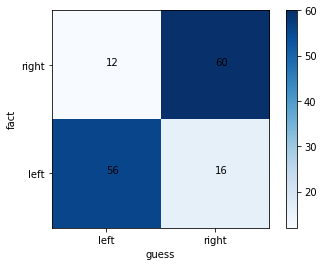

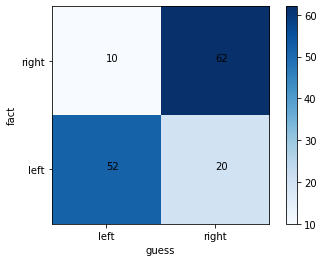

{'train': 0.8055555555555556, 'valid': 0.7916666666666666}


In [17]:
def train_lda(data, labels):
    classifier = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))
    classifier.fit(data, labels)
    return classifier

eval_classifier(train_lda(V_train, T_train), data={'train': V_train, 'valid': V_valid}, labels={'train': T_train, 'valid': T_valid})

*Yes, in terms of accuracy, the classifier did pretty well and did not overfit.*

# 3. Extension: Laplacian spatial filter<a class="anchor" id="extension1"></a>
Instead of preselecting certain channels, we can utilize the fact that multiple electrodes were used to record the EEG. These electrodes can be used to add information about the signal that we are interested in, but can also help in removing noise sources. The first spatial filter that we will employ is the Laplacian.

### 3.1. The Laplacian (1 point) <a class="anchor" id="laplacian"></a>
The Laplacian in general takes the first derivative, in this case a spatial derivative. A simple way of implementing this is to make center-surround configurations. Specifically:
$$y(t)_i = n*y(t)_i - \sum^n_j y(t)_j$$
where $i$ is the to be filtered electrode, and $j$ are the neighbours of $i$. 

Let's focus again on C3 and C4, this means:
$$y(t)_{C3} = 4*y(t)_{C3} - y(t)_{FC3} - y(t)_{C5} - y(t)_{C1} - y(t)_{CP3}$$
$$y(t)_{C4} = 4*y(t)_{C4} - y(t)_{FC4} - y(t)_{C2} - y(t)_{C6} - y(t)_{CP4}$$
Implement a function `laplacian(X, ch)` that computes the laplacian for channel `ch` that is either C3 or C4.

Apply the function to both training and validation data, storing them in `F_train` and `F_valid`.


In [31]:
def laplacian_channel(X, ch):
    if ch == 'C3':
         return 4*X[:,:,channels.index(ch)]-X[:,:,channels.index('FC3')]-X[:,:,channels.index('C5')]-X[:,:,channels.index('C1')]-X[:,:,channels.index('CP3')]
    elif ch == 'C4':
        return 4*X[:,:,channels.index(ch)]-X[:,:,channels.index('FC4')]-X[:,:,channels.index('C2')]-X[:,:,channels.index('C6')]-X[:,:,channels.index('CP4')]
    else:
        raise ValueError('channel must be one of C3, C4')

def laplacian(data):
    result = []
    result.append(laplacian_channel(data, 'C3'))
    result.append(laplacian_channel(data, 'C4'))
    return np.stack(result, axis=-1)

In [32]:
L_train = laplacian(X_train)
L_valid = laplacian(X_valid)

print(f'L_train shape: {L_train.shape}, dtype: {L_train.dtype}')
print(f'L_valid shape: {L_valid.shape}, dtype: {L_valid.dtype}')

L_train shape: (144, 750, 2), dtype: float32
L_valid shape: (144, 750, 2), dtype: float32


### 3.2. Bandpower features (0.5 points) <a class="anchor" id="bandpower2"></a>
Now, compute the bandpower features like before, but this time for the spatially filtered C3 and C4 channels. You can reuse (parts of) your code from above.

In [33]:
LF_train = get_bands(L_train, [(8, 12), (12, 30)], electrodes, ['C3', 'C4'])
LF_valid = get_bands(L_valid, [(8, 12), (12, 30)], electrodes, ['C3', 'C4'])

print(f'LF_train shape: {LF_train.shape}, dtype: {LF_train.dtype}')
print(f'LF_valid shape: {LF_valid.shape}, dtype: {LF_valid.dtype}')

LF_train shape: (144, 2, 2), dtype: float64
LF_valid shape: (144, 2, 2), dtype: float64


### 3.3. Visualizing features (0.5 points) <a class="anchor" id="features2"></a>
Like before, visualize the bandpower features per channel in a bar plot. You can reuse (parts of) your code from above. 

Did the features benefit from the Laplacian?

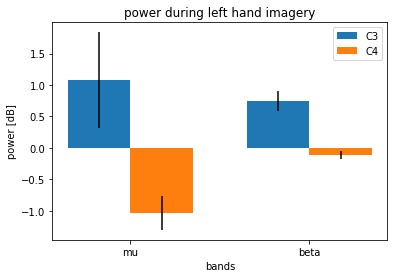

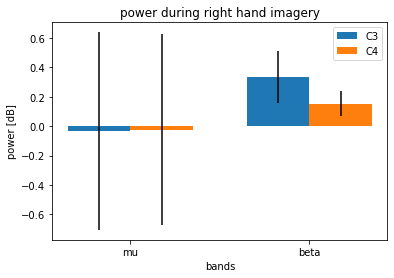

In [34]:
hand_power_plot(LF_train, T_train, 'left')
hand_power_plot(LF_train, T_train, 'right')

_Yes, the features did benefit - except maybe for the poor mu band during right-hand imagery, as to which - after much investigation - we still have no idea why it's so weird. But now we can see substantial differentiation between left- and right-hand imagery in the beta band!_

### 3.4. Decoding (0.5 points)<a class="anchor" id="decoding2"></a>
Like before, vectorize the features, setup a decoding pipeline, calibrate the classifier, predict the labels, compute classification accuracies and plot confusion matrices. You can reuse (parts of) your code from above. 

Did the decoding benefit from the Laplacian?

In [35]:
VLF_train = np.reshape(np.ravel(LF_train), (-1, 4)) # vectorized features
VLF_valid = np.reshape(np.ravel(LF_valid), (-1, 4))

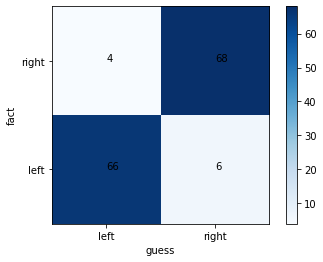

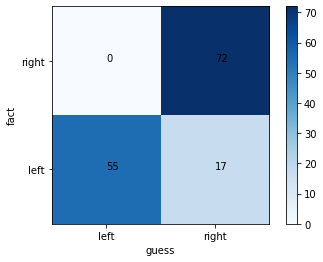

{'train': 0.9305555555555556, 'valid': 0.8819444444444444}


In [36]:
eval_classifier(train_lda(VLF_train, T_train), data={'train': VLF_train, 'valid': VLF_valid}, labels={'train': T_train, 'valid': T_valid})

_Yes, the classifier did benefit! We now achieve a validation accuracy of 88%, significantly better than the 79% before. We can see that our classifier has a strong positive bias for right-hand imagery - perhaps this is connected to the strange band powers as seen in the bar plots above._

# 4. Extension: Common spatial patterns <a class="anchor" id="extension2"></a>
The Laplacian is based on geometric information. Instead, we can also inform the spatial filter about the task. Such type of spatial filter is a supervised one, and an example is common spatial patterns.

### 4.1. The CSP (1.5 points)<a class="anchor" id="csp"></a>
The CSP computes spatial filters by optimizing the following:
$$W = {\arg\max}_W\frac{W^\top X_0}{W^\top X_1}$$
Specifically, it optimizes a spatial filter in such a way that the variance of the one class is maximized while minimizing the variance of the other class. In other words, it separates the two classes by maximizing the difference in their variance. The above formulation is for a two-class problem, but the CSP can be applied to multiclass problems too by optimizing task-specific (one versus rest) $W$'s. 

The above is solved by first computing task-specific covariance matrices $C_0$ and $C_1$ with `np.cov()` on reshaped and permuted data of shape $X \in \mathbb{R}^{c, k*m}$. Specifically, compute a covariance matrix `C0` using the channel-wise covariance of left-hand data, and another `C1` for right-hand data. Then, we perform a generalized eigenvalue decomposition by performing `D, V = eig(C_0, C_1)`. This decomposition makes sure that $V^\top C_0V=D$ and $V^\top C_1=I$. This is equivalent to performing an eigen decomposition with $C_0^\top C_1=V^\top DV$.

Write a function `fit_csp(X, Y)` that performes the above steps. Make sure that the eigenvectors are sorted on decreasing eigenvalues. Return the eigenvectors (i.e., these are the spatial filters). Use the function to fit CSPs using the training data, outputing the spatial filters as `W`.

In [24]:
# code here.

Now, write a function `apply_csp(X, W)` that takes one CSP `W` (i.e., one spatial filter), and applies it to the data in `X`. This is an easy mathematical operation, performed by looping over trials or by reshaping the data to a 2D matrix.

Use the function to spatially filter both training and validation data. Do so making use of 3 CSP pairs. Specifically, use the first 3 components and last 3 components (i.e., the components are the eigenvectors). Stack these in variables `F_train` and `F_valid`, as if we have 6 channels. 


In [25]:
# code here.

In [26]:
print("F_train:", F_train.shape, F_train.dtype)
print("F_valid:", F_valid.shape, F_valid.dtype)


F_train: (144, 2, 2) float64
F_valid: (144, 2, 2) float64


### 4.2. Bandpower features (0.5 points)<a class="anchor" id="bandpower3"></a>
Now, compute the bandpower features like before, but this time for the CSP patterns. You can reuse (parts of) your code from above.

In [27]:
# code here.

### 4.3. Visualizing features (0.5 points)<a class="anchor" id="features3"></a>
Like before, visualize the bandpower features per channel in a bar plot. You can reuse (parts of) your code from above. Note, we have more "channels" now.

Did the features benefit from the CSP?

In [28]:
# code here.

### 4.4. Decoding (0.5 points)<a class="anchor" id="decoding3"></a>
Like before, vectorize the features, setup a decoding pipeline, calibrate the classifier, predict the labels, compute classification accuracies and plot confusion matrices. You can reuse (parts of) your code from above. 

Did the decoding benefit from the CSP?

In [29]:
# code here.

### 4.5. Inspect classifier (0.5 points)<a class="anchor" id="classifier"></a>
We can inspect the classifier to obtain insight in what the classifier learned. Use the `topoplot()` function with the `assignment2_channels.txt` layout file to plot the first and last CSP in `W`. 

Can you explain what the spatial filters mean? Specifically, why do you observe the clear lateralisation?

In [30]:
# code here.